In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import Latex
from sympy import * 
from iminuit import Minuit
import seaborn as sns
import pandas as pd
import scipy as sp
import sys                                             # Modules to see files and folders in directories
sys.path.append('External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure
from scipy.stats import binom, poisson, norm

In [3]:

def lprint(*args,**kwargs):
    """Pretty print arguments as LaTeX using IPython display system 
    
    Parameters
    ----------
    args : tuple 
        What to print (in LaTeX math mode)
    kwargs : dict 
        optional keywords to pass to `display` 
    """
    display(Latex('$$'+' '.join(args)+'$$'),**kwargs)

In [153]:
g,a,DB,DR,T1,T2= symbols("g,a,D_{ball},D_{rail},theta,theta_Delta")
dDB,dDr,dT,dTd,da,dg= symbols("sigma_DB, sigma_Dr, sigma_theta, sigma_Delta ,sigma_a,sigma_g")

In [154]:
g=a/( T1 + T2 )*((1)+(2/5)*DB**2/(DB**2-DR**2))
dg=sqrt((da*g.diff(a))**2+(g.diff(DB)*dDB)**2+(g.diff(dDr)*dDr)**2+(g.diff(T1)*dT)**2+(g.diff(T2)*dTd)**2)
lprint(latex(Eq(symbols('g'), g)))
lprint(latex(Eq(symbols('sigma_g'), dg)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [6]:
A=np.loadtxt("data_NormDir_MedBall1.txt")
A1=np.loadtxt("data_RevDir_MedBall1.txt")

In [156]:
Data={"Time":A[:,0],"Voltages":A[:,1],"Time_Norm":A1[:,0],"Voltages_Norm":A1[:,1]}


In [157]:
Data1_pend=pd.DataFrame(Data)


In [158]:
def data_sorting(Time,Voltages):
    Voltages_rescaled=np.array(Voltages-min(Voltages))
    Voltages_rescaled_nonzeros=Voltages_rescaled[Voltages_rescaled>0.1]
    Voltages_rescaled_nonzeros_mtop=Voltages_rescaled_nonzeros[Voltages_rescaled_nonzeros<4]
    Time_rescaled=Time[Voltages_rescaled>0.1]
    Time_rescaled_mtop=Time_rescaled[Voltages_rescaled_nonzeros<4]
    DT=Time_rescaled_mtop-np.roll(Time_rescaled_mtop,-1)
    DV=Voltages_rescaled_nonzeros_mtop-np.roll(Voltages_rescaled_nonzeros_mtop,-1)
    a=DV/DT
    inroll=Time_rescaled_mtop[np.where(a>10,1,0).astype(bool)]
    outroll=Time_rescaled_mtop[np.where(a<-10,1,0).astype(bool)]
    DT_in=np.roll(inroll,1)-inroll
    index_in=list(np.where(abs(DT_in)>0.08)[0])
    index_in.append(len(inroll)-1)
    DT_out=np.roll(outroll,1)-outroll
    index_out=list(np.where(abs(DT_out)>0.08)[0])
    index_out.append(len(outroll)-1)
    return inroll,outroll,np.array(index_in),np.array(index_out)

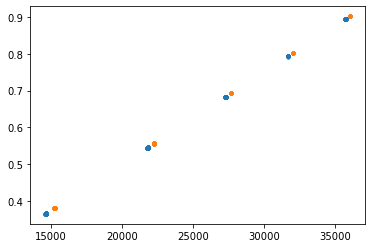

In [159]:
#plt.plot(Data1_pend.Time,Data1_pend.Voltages)
plt.plot(inroll,'.')
plt.plot(outroll,'.')

In [168]:
def mean_roll(inroll,outroll):
    mean_roll=[]
    std_roll=[]
    for i in range(len(in_index)-1):
        mean_roll.append((np.mean(outroll[out_index[i]:out_index[i+1]])+np.mean(inroll[in_index[i]:in_index[i+1]]))/2)
        std_roll.append((np.std(outroll[out_index[i]:out_index[i+1]])+np.std(inroll[in_index[i]:in_index[i+1]]))/2)
    return mean_roll,std_roll

In [171]:
inroll,outroll,in_index,out_index=data_sorting(Data1_pend.Time,Data1_pend.Voltages)
inroll_Norm,outroll_Norm,in_index_Norm,out_index_Norm=data_sorting(Data1_pend.Time_Norm,Data1_pend.Voltages_Norm)
inroll_mean,introll_std=mean_roll(inroll,outroll)
inroll_mean_Norm,introll_std_Norm=mean_roll(inroll_Norm,outroll_Norm)

In [175]:
print(inroll_mean)
print(inroll_mean_Norm)

[0.37384375000000003, 0.55105625, 0.6877000000000001, 0.79699375, 0.89755625]
[0.35667109375000006, 0.531216902173913, 0.6665005263157895, 0.777563564908722, 0.9798074461722488]


In [23]:
H=np.array([0.16,0.32,0.48,0.64,0.08])

In [24]:
def fit_function_Lin(x, slope, intercept ):
    return intercept + 1/2*slope*x**2
    
chi2_object = Chi2Regression(fit_function_Lin,mean_roll,H, std_roll )
minuitLin = Minuit(chi2_object, pedantic=False, intercept=0, slope=1, print_level=0) 
minuitLin.migrad(); 
Chi2Lin = minuitLin.fval
NdofLin = len(A[:,0])- 2  # Number of degrees of freedom
    
#from scipy import stats
ProbLin =  sp.stats.chi2.sf(Chi2Lin, NdofLin) # The chi2 probability given N_DOF degrees of freedom
    
array_Chi2_Lin= Chi2Lin
array_Prob_Lin= ProbLin

In [25]:
inroll,outroll,in_index,out_index=data_sorting(Data1_pend.Time,Data1_pend.Voltages)
mean_pos=[]
for i in range(len(in_index)-1):
    mean_pos.append(np.mean(inroll[in_index[i]:in_index[i+1]])-np.mean(outroll[out_index[i]:out_index[i+1]]))



In [26]:
x=np.linspace(0,0.7,100)

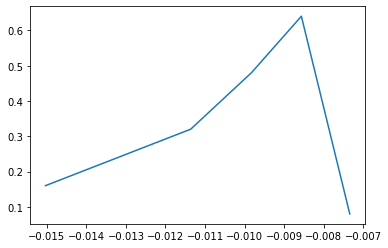

In [27]:
plt.plot(mean_pos,H)

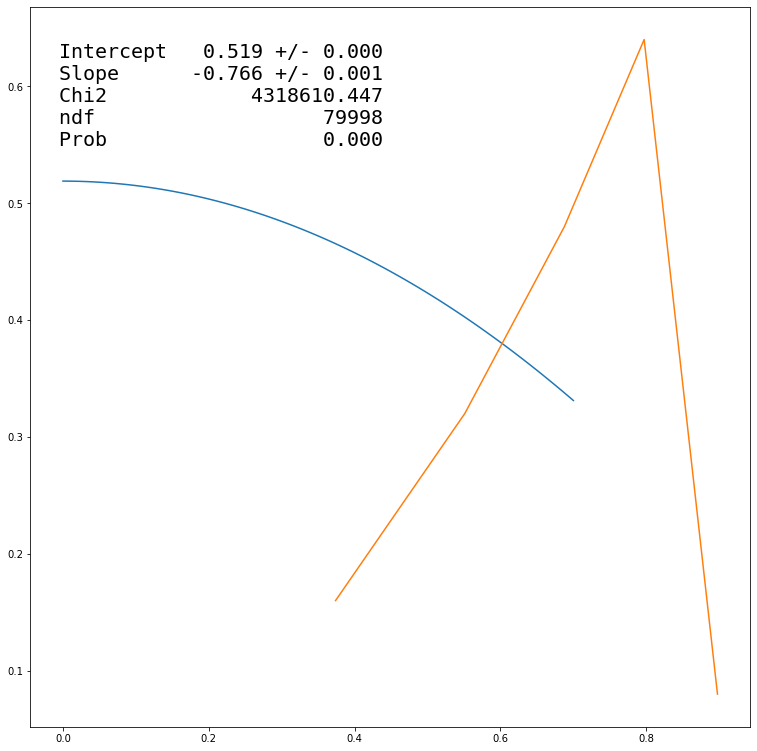

In [28]:

fig=plt.figure(figsize=(10,10))
ax=fig.add_axes([0,0,1,1])
ax.plot(x, fit_function_Lin(x, *minuitLin.args),'-')
ax.plot(mean_roll,H)
d = {'Intercept':[minuitLin.values['intercept'], minuitLin.errors['intercept']],
     'Slope':    [minuitLin.values['slope'], minuitLin.errors['slope']],
     'Chi2':     Chi2Lin,
     'ndf':      NdofLin,
     'Prob':     ProbLin,
    }
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.04, 0.95, text, ax, fontsize=20)


